[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/lmodel_analysis/shap_values_tutorial.ipynb)

To use visualization you need to install shap library:
pip install shap

In this tutorial we use a large part of Shap values tutorial from the [githab of shap](https://github.com/slundberg/shap)

In [1]:
import catboost
from catboost import *
import shap
shap.initjs() 

Let's first explore shap values for dataset with numeric features

In [2]:
X,y = shap.datasets.boston()

In [3]:
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(X, y, verbose=False, plot=False)

In [4]:
shap_values = model.get_feature_importance(Pool(X, y), type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

# visualize the first prediction's explanation
shap.force_plot(expected_value, shap_values[0,:], X.iloc[0,:])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [5]:
# visualize the training set predictions
shap.force_plot(expected_value, shap_values, X)

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted house price as RM (the average number of rooms per house in an area) changes. Vertical dispersion at a single value of RM represents interaction effects with other features. To help reveal these interactions `dependence_plot` automatically selects another feature for coloring. In this case coloring by RAD (index of accessibility to radial highways) highlights that RM has less impact on home price for areas close to radial highways.

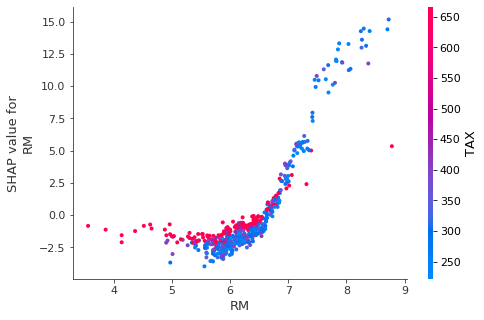

In [6]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("RM", shap_values, X)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that a high LSTAT (% lower status of the population) lowers the predicted home price.

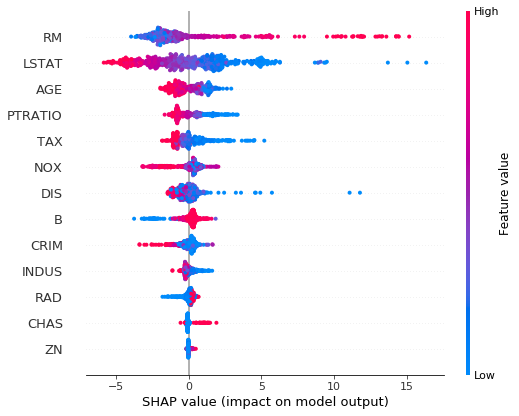

In [7]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

Sometimes it might be helpful to use logarithmic scale.

In [9]:
# This feature will be available after the release of shap library version "0.36.0"
# shap.summary_plot(shap_values, X, use_log_scale=True)

You can choose to display on the summary plot only the most important features.

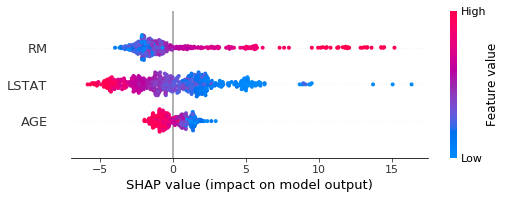

In [10]:
shap.summary_plot(shap_values, X, max_display=3)

You can also specify feature names.

In [11]:
# This feature will be available after the merge of the following pull request: https://github.com/slundberg/shap/pull/1180
# shap.summary_plot(shap_values, X, display_features=['TAX', 'CRIM'])

You can also use shap values to analyze importance of categorical features

In [8]:
from catboost.datasets import *
train_df, test_df = catboost.datasets.amazon()
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)
cat_features = list(range(0, X.shape[1]))

In [9]:
model = CatBoostClassifier(iterations=300, learning_rate=0.1, random_seed=12)
model.fit(X, y, cat_features=cat_features, verbose=False, plot=False)

In [10]:
shap_values = model.get_feature_importance(Pool(X, y, cat_features=cat_features), type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

Here is the visualization of feature importances for one positive and one negative example.
Note, that binary classification output is a value not in range `[0,1]`. You need to calculate a sigmoid function value, to calculate final probabilities.

In [11]:
test_objects = [X.iloc[0:1], X.iloc[91:92]]

for obj in test_objects:
    print('Probability of class 1 = {:.4f}'.format(model.predict_proba(obj)[0][1]))
    print('Formula raw prediction = {:.4f}'.format(model.predict(obj, prediction_type='RawFormulaVal')[0]))
    print('\n')


Probability of class 1 = 0.9975
Formula raw prediction = 5.9738


Probability of class 1 = 0.0536
Formula raw prediction = -2.8714




In [12]:
shap.force_plot(expected_value, shap_values[0,:], X.iloc[0,:])

In [13]:
shap.force_plot(expected_value, shap_values[91,:], X.iloc[91,:])

In the summary plot below you can see that absolute values of the features don't matter, because it's hashes. But it is clear from the plot what is the effect of different features.

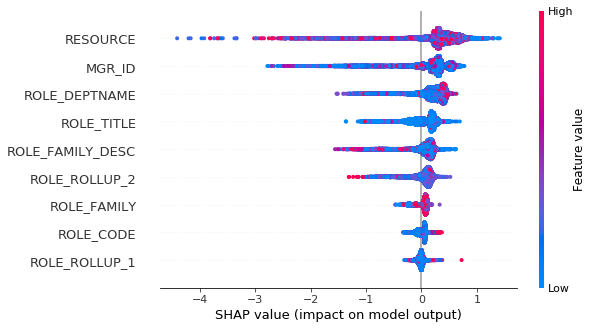

In [14]:
shap.summary_plot(shap_values, X)

You can calculate shap values for multiclass.

In [15]:
model = CatBoostClassifier(loss_function = 'MultiClass', iterations=300, learning_rate=0.1, random_seed=123)
model.fit(X, y, cat_features=cat_features, verbose=False, plot=False)


In [16]:
shap_values = model.get_feature_importance(Pool(X, y, cat_features=cat_features), type='ShapValues')

shap_values = shap_values[:,:,:-1]

In [17]:
shap_values.shape

(32769, 2, 9)

Summary plot of SHAP values for formula raw predictions for class 0.

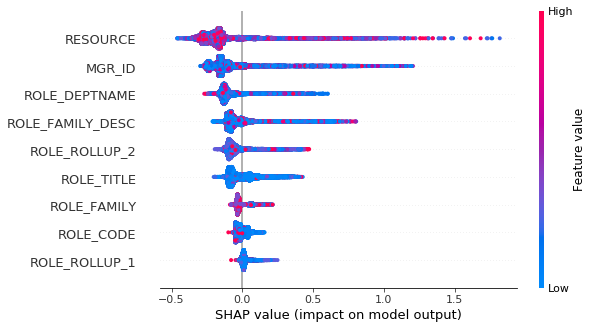

In [18]:
shap.summary_plot(shap_values[:,0], X)

And force plot for class 1.

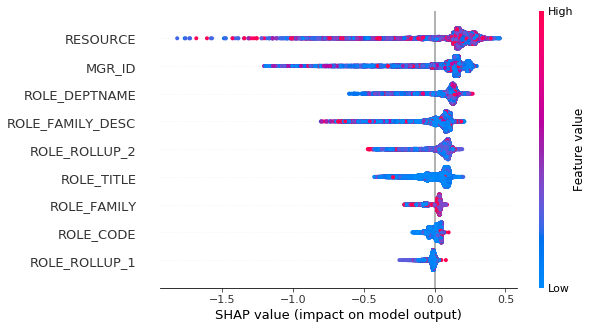

In [19]:
shap.summary_plot(shap_values[:,1], X)

There are several calculation types which could be set using 'shap_calc_type' parameter for 'get_feature_importance' function. These types are 'Normal' (default), 'Approximate' (works much faster, gives less accurate results), 'Exact' (works slower, but allows to calculate more accurate results).

In [20]:
X, y = shap.datasets.boston()
pool = Pool(X, y)
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123).fit(pool, verbose=False, plot=False)

Time evaluations for different calculation types.

In [21]:
%time approximate = model.get_feature_importance(pool, type="ShapValues", shap_calc_type="Approximate")[:, :-1]

CPU times: user 37.5 ms, sys: 8.6 ms, total: 46.1 ms
Wall time: 27.6 ms


In [22]:
%time normal = model.get_feature_importance(pool, type="ShapValues", shap_calc_type="Regular")[:, :-1]

CPU times: user 521 ms, sys: 11.8 ms, total: 533 ms
Wall time: 168 ms


In [23]:
%time exact = model.get_feature_importance(pool, type="ShapValues", shap_calc_type="Exact")[:, :-1]

CPU times: user 749 ms, sys: 0 ns, total: 749 ms
Wall time: 213 ms


Summary plots for different calculation types.

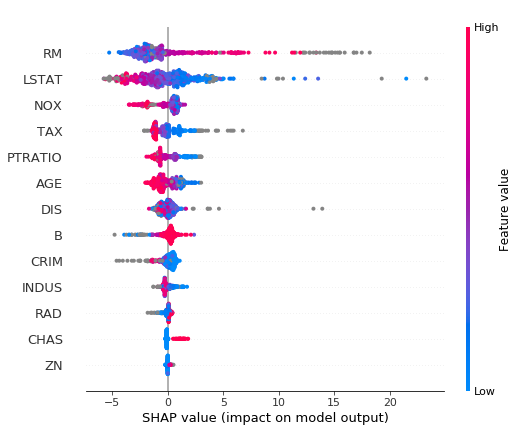

In [24]:
shap.summary_plot(approximate, X)

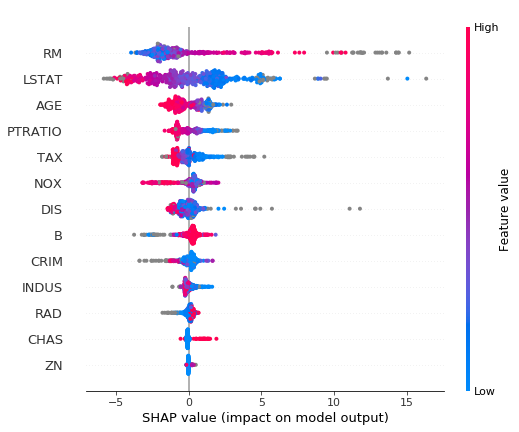

In [25]:
shap.summary_plot(normal, X)

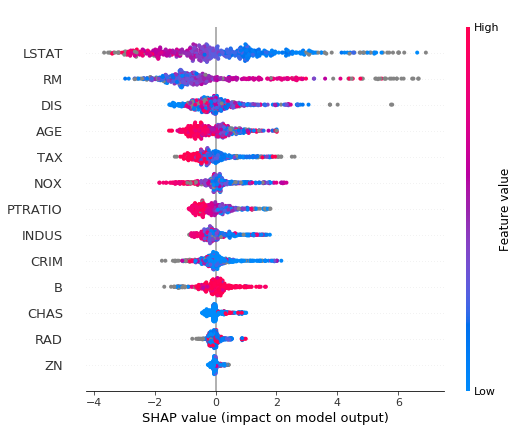

In [26]:
shap.summary_plot(exact, X)